In [1]:
import tensorflow as tf
len(tf.config.list_physical_devices('GPU'))


1

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)  # Allocate all memory upfront
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]  # Use full GPU memory
            )
        print("Forced full GPU allocation.")
    except RuntimeError as e:
        print(e)


Forced full GPU allocation.


In [3]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
folder_path = r'C:\Users\write\Desktop\ai\AI-Development\DL\UTKFace\utkface_aligned_cropped\UTKFace'

In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
age = []
gender = []
img_path = []

for file in os.listdir(folder_path):
    age.append(int(file.split('_')[0]))
    gender.append(int(file.split('_')[1]))
    img_path.append(file)


In [7]:
len(age)

23708

In [8]:
df = pd.DataFrame({'age': age, 'gender': gender, 'img': img_path})

In [9]:
df.shape

(23708, 3)

In [10]:
df.head()

,age,gender,img
0,100,0,100_0_0_20170112213500903.jpg.chip.jpg
1,100,0,100_0_0_20170112215240346.jpg.chip.jpg
2,100,1,100_1_0_20170110183726390.jpg.chip.jpg
3,100,1,100_1_0_20170112213001988.jpg.chip.jpg
4,100,1,100_1_0_20170112213303693.jpg.chip.jpg


In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)


In [12]:
train_df['age'] = train_df['age'].astype(float)
train_df['gender'] = train_df['gender'].astype(int)  # binary (0 or 1)

In [13]:
train_df.shape

(18966, 3)

In [14]:
test_df.shape

(4742, 3)

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [16]:
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=folder_path,
    x_col='img',
    y_col=['age', 'gender'],  # providing 2 output as we are working on 2 output model
    target_size=(200,200),
    class_mode='raw',  # multi_output because output are more than 1
    batch_size=batch_size,
    
)

test_generator = train_datagen.flow_from_dataframe(
    test_df,
    directory=folder_path,
    x_col='img',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    class_mode='raw',
    batch_size=batch_size,
)

Found 18966 validated image filenames.
Found 4742 validated image filenames.


In [17]:
# Function to modify generator output structure
def process_generator(generator):

    for batch_x, batch_y in generator:
        yield batch_x, {'age': batch_y[:, 0], 'gender': batch_y[:, 1]}

# Apply the function to generators
train_generator_fixed = process_generator(train_generator)
test_generator_fixed = process_generator(test_generator)

In [18]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [19]:
vggnet = VGG16(include_top=False, input_shape=(200, 200, 3))

In [20]:
vggnet.trainable=False

output=vggnet.layers[-1].output  # getting only output layer of vggnet

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512, activation='relu')(flatten)

dense3 = Dense(512, activation='relu')(dense1)
dense4 = Dense(512, activation='relu')(dense2)

output1 = Dense(1, activation='linear', name='age')(dense3)   # we can also define the name of any output layer
output2 = Dense(1, activation='sigmoid', name='gender')(dense4)

In [21]:
model = Model(inputs=vggnet.input, outputs=[output1, output2]) # getting input of the vggnet input and output we defined

model.summary()

In [22]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'})

In [23]:
history = model.fit(
    train_generator_fixed,
    steps_per_epoch=5000 // batch_size,
    validation_steps=3000 // batch_size,
    epochs=50,
    validation_data=test_generator_fixed,
)




Epoch 1/50
156/156 [==============================] - 201s 1s/step - loss: 13.3616 - age_loss: 12.7025 - gender_loss: 0.6591 - age_mae: 12.7025 - gender_accuracy: 0.6881 - val_loss: 11.3692 - val_age_loss: 10.8434 - val_gender_loss: 0.5258 - val_age_mae: 10.8434 - val_gender_accuracy: 0.7174
Epoch 2/50
156/156 [==============================] - 191s 1s/step - loss: 11.3773 - age_loss: 10.8853 - gender_loss: 0.4919 - age_mae: 10.8853 - gender_accuracy: 0.7614 - val_loss: 10.6327 - val_age_loss: 10.1352 - val_gender_loss: 0.4975 - val_age_mae: 10.1352 - val_gender_accuracy: 0.7485
Epoch 3/50
156/156 [==============================] - 185s 1s/step - loss: 10.4363 - age_loss: 9.9895 - gender_loss: 0.4468 - age_mae: 9.9895 - gender_accuracy: 0.7891 - val_loss: 9.9858 - val_age_loss: 9.5743 - val_gender_loss: 0.4115 - val_age_mae: 9.5743 - val_gender_accuracy: 0.8071
Epoch 4/50
156/156 [==============================] - 198s 1s/step - loss: 9.9048 - age_loss: 9.4679 - gender_loss: 0.4369 - a

In [24]:
from matplotlib import pyplot as plt

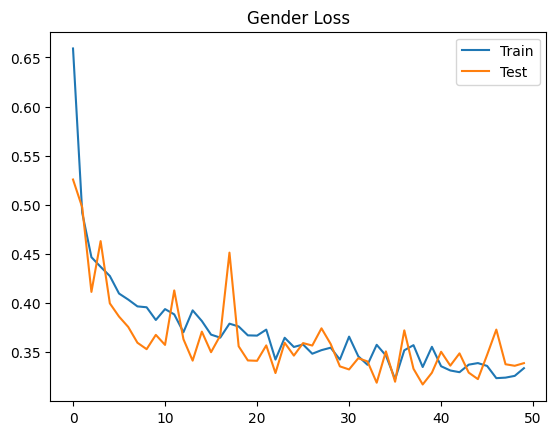

In [25]:

plt.title('Gender Loss')
plt.plot(history.history['gender_loss'], label='Train')
plt.plot(history.history['val_gender_loss'], label='Test')
plt.legend()
plt.show()

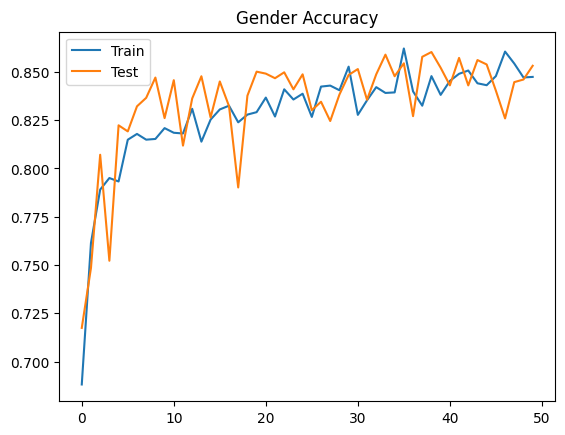

In [26]:
plt.title('Gender Accuracy')

plt.plot(history.history['gender_accuracy'], label='Train')
plt.plot(history.history['val_gender_accuracy'], label='Test')
plt.legend()
plt.show()

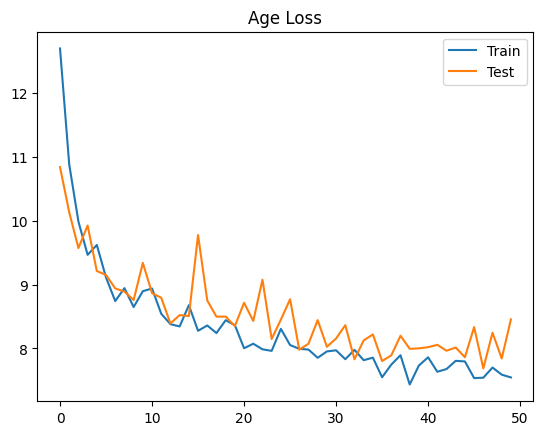

In [27]:
plt.title('Age Loss')

plt.plot(history.history['age_loss'], label='Train')
plt.plot(history.history['val_age_loss'], label='Test')
plt.legend()
plt.show()

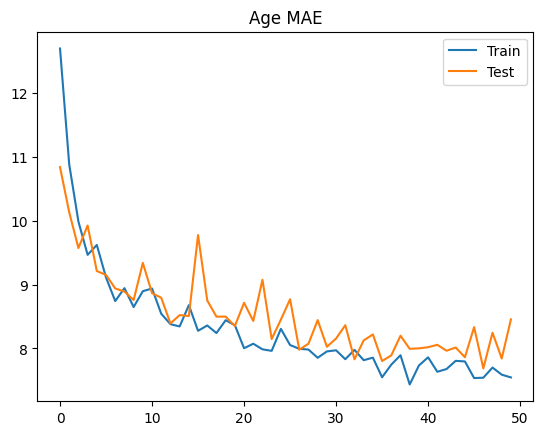

In [28]:
plt.title("Age MAE")

plt.plot(history.history['age_mae'], label='Train')
plt.plot(history.history['val_age_mae'], label='Test')
plt.legend()
plt.show()

In [29]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
